<a href="https://colab.research.google.com/github/isisvlara/Projects/blob/main/10_2_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras

In [ ]:
df = pd.read_csv("startups_profit.csv")
df.head(1)

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.2,136897.8,471784.1,New York,"$192,261.83"


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4    Profit          50 non-null     object 
dtypes: float64(3), object(2)
memory usage: 2.1+ KB


In [ ]:
df.columns = df.columns.str.strip()

In [ ]:
df['Profit'] = df['Profit'].replace('[\$,]', '', regex=True).astype(float)

I will be using OneHotEncoder() over get_dummies for explicit feature representation. Last time, in week 8, I used both because I really didn't understand the difference. This article says they offer the same result: https://pythonsimplified.com/difference-between-onehotencoder-and-get_dummies/ but there are some key differences to keep in mind then I stopped reading. I should have continued reading, the article does state "inconsistent with train data and will eventually fail during the model building process," for get_dummies.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_features = ['R&D Spend', 'Administration', 'Marketing Spend']
categorical_features = ['State']

preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), numeric_features), ('cat', OneHotEncoder(drop='first'), categorical_features)])

x = df.drop('Profit', axis=1)
y = df['Profit']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train_process = preprocessor.fit_transform(x_train)
x_test_process = preprocessor.transform(x_test)


I am trying not to overthink the neural network model. I know there are only 50 entries in the dataset, and scikit-learn is best for the assignment. Still, I want to get comfortable with Tensorflow since it is favored over scikit-learn. I plan to work with larger datasets (the goal is to get into genomic data science in biomedicine, and they heavily use Tensorflow for genome sequencing analysis. By the way, UCLA has a master's program in Data science in biomedicine. Soooo, have you ever wanted to write a letter of recommendation for a student before?? ).

In [ ]:
num_features = x_train_process.shape[1]

# Creating a "funnel-like" structure helps the network learn hierarchical representations of the data, moving from general to more specific features. I am also choosing the Rectified Linear Unit (ReLU) activation function for computational efficiency.
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(num_features,)), # 64 to capture broad range of features
    tf.keras.layers.Dense(32, activation='relu'), # 32 Gradually distill to the mose relevant
    tf.keras.layers.Dense(16, activation='relu'), # 16 Gradually distill to the most relevant
    tf.keras.layers.Dense(1) # output layer with 1 neuron (for predicting the profit)
])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

history = model.fit(x_train_process, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
test_loss, test_mae = model.evaluate(x_test_process, y_test, verbose=0)
print(f"Test Mean Absolute Error: {test_mae:.2f}")

Test Mean Absolute Error: 97445.61


In [ ]:
predictions = model.predict(x_test_process)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Predicted model performance metrics \nMean Absolute Err: {mae:.2f}, \nMean Squared Error: {mse:.2f}, \nr2 score: {r2:.2f}")

Predicted model performance metrics 
Mean Absolute Err: 97445.61, 
Mean Squared Error: 10305547259.11, 
r2 score: -11.73


Inner thought: "Well aren't you predicting very poorly, that's so kind." Perhaps, tensor flow with ReLU was a poor choice. Second attempt but with scikit-learn

In [ ]:
from sklearn.neural_network import MLPRegressor

model_2 = MLPRegressor(hidden_layer_sizes=(64, 32, 16), max_iter=1000, random_state=42)

model_2.fit(x_train_process, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(64, 32, 16), max_iter=1000, random_state=42)

In [ ]:
y_pred = model.predict(x_test_process)

mae_two = mean_absolute_error(y_test, y_pred)
mse_two = mean_squared_error(y_test, y_pred)
r2_two = r2_score(y_test, y_pred)

print(f"Predicted model performance metrics \nMean Absolute Err: {mae_two:.2f}, \nMean Squared Error: {mse_two:.2f}, \nr2 score: {r2_two:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted model performance metrics 
Mean Absolute Err: 97445.61, 
Mean Squared Error: 10305547259.11, 
r2 score: -11.73


Whoa, what is happening !? Well, never mind on that letter of recommendation; this is just awful. Ok, so the negative value implies that the model introduces more error than it explains variance in the target variable. I am going to restart and use get_dummies instead of OneHotEncoder and continue using scikit-learn.

In [ ]:
data = pd.read_csv('startups_profit.csv')

data.columns = data.columns.str.strip()
data['Profit'] = data['Profit'].str.replace('$', '').str.replace(',', '').astype(float)

X = data[['R&D Spend', 'Administration', 'Marketing Spend']]
y = data['Profit']

X = pd.get_dummies(data, columns=['State'], prefix='State')
X = X.drop('Profit', axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
model_three = MLPRegressor(hidden_layer_sizes=(64, 32, 16), activation='relu', max_iter=1000, random_state=42) # same funnel structure and choosing relu for computational effeciency, again

model_three.fit(X_train_scaled, Y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(64, 32, 16), max_iter=1000, random_state=42)

In [ ]:
y_pred_three = model_three.predict(X_test_scaled)

ma = mean_absolute_error(Y_test, y_pred_three)
ms = mean_squared_error(Y_test, y_pred_three)
r = r2_score(Y_test, y_pred_three)

print(f"Predicted model performance metrics \nMean Absolute Err: {ma:.2f}, \nMean Squared Error: {ms:.2f}, \nr2 score: {r:.2f}")

Predicted model performance metrics 
Mean Absolute Err: 19788.10, 
Mean Squared Error: 537543734.49, 
r2 score: 0.34


That accuracy score is better than -11. Lessoned learned: use get_dummies! I am going to have to dive further into the difference in OneHotEncoder and get_dummies; the outcome of the accuracy between the three models is drastic. While the third model has learned some patterns in the data, there is still significant room for improvement. The MAE indicates that, on average, the model's predictions deviate by about $19,788 from the actual profit values.

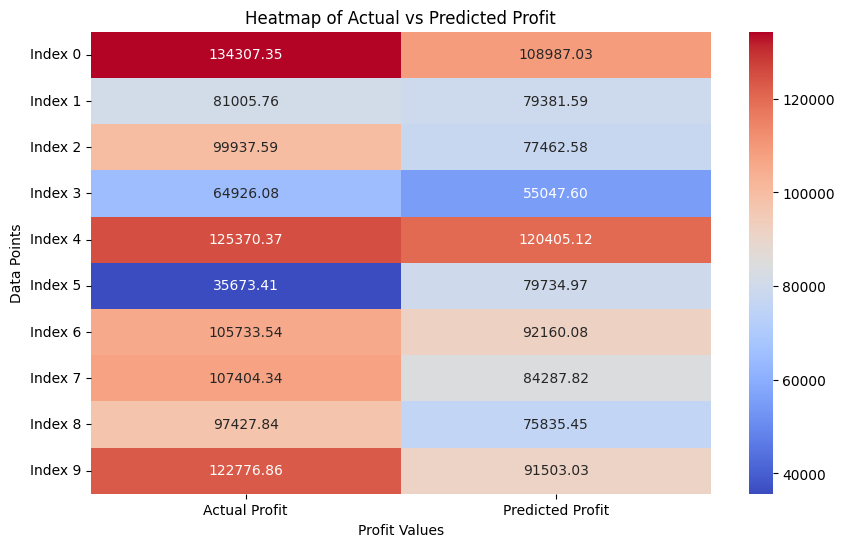

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

matrix = np.array([Y_test, y_pred_three.flatten()]).T

plt.figure(figsize=(10, 6))
sns.heatmap(matrix, annot=True, fmt='.2f', cmap='coolwarm',
            xticklabels=['Actual Profit', 'Predicted Profit'],
            yticklabels=[f'Index {i}' for i in range(len(Y_test))])
plt.title('Heatmap of Actual vs Predicted Profit')
plt.xlabel('Profit Values')
plt.ylabel('Data Points')
plt.show()